# 2 Data wrangling

## 2.2 Introduction

This step focuses on collecting your data, organizing it, and making sure it's well defined.

### 2.2.1 Recap Of Data Science Problem

The purpose of this data science project is to predict time to failure given each small segment of acoustic signal using a data-driven model

## 2.3 Imports

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import numpy as np
import glob, os
pd.set_option("display.precision", 8)
from scipy import signal



## 2.4 Objectives

There are some fundamental questions to resolve in this notebook before you move on.

* Do you think you may have the data you need to tackle the desired question?
    * Have you identified the required target value?
    * Do you have potentially useful features?
* Do you have any fundamental issues with the data?
* Do your column names correspond to what those columns store?
    * Check the data types of your columns. Are they sensible?
    * Calculate summary statistics for each of your columns, such as mean, median, mode, standard deviation, range, and number of unique values. What does this tell you about your data? What do you now need to investigate?

# 2.5 Load the training data

## 2.5.1 Check a small section of data

In [4]:
filename = 'D:/DataScience/rawdata/2ndCapstone/train.csv'

In [5]:
# df_tr_sec =  pd.read_csv(filename,nrows = 6e6)
records = 300000
df_tr_sec =  pd.read_csv(filename,nrows = records)


In [6]:
df_tr_sec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   acoustic_data    300000 non-null  int64  
 1   time_to_failure  300000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 4.6 MB


In [7]:
df_tr_sec.describe()

,acoustic_data,time_to_failure
count,300000.00000000,300000.00000000
mean,4.80494000,1.43070303
std,5.89263048,0.02249537
min,-154.00000000,1.39149889
25%,2.00000000,1.41169579
50%,5.00000000,1.43079719
75%,7.00000000,1.44999858
max,181.00000000,1.46909998


In [8]:
df_tr_sec.head()

,acoustic_data,time_to_failure
0,12,1.46909998
1,6,1.46909998
2,8,1.46909998
3,5,1.46909998
4,8,1.46909998


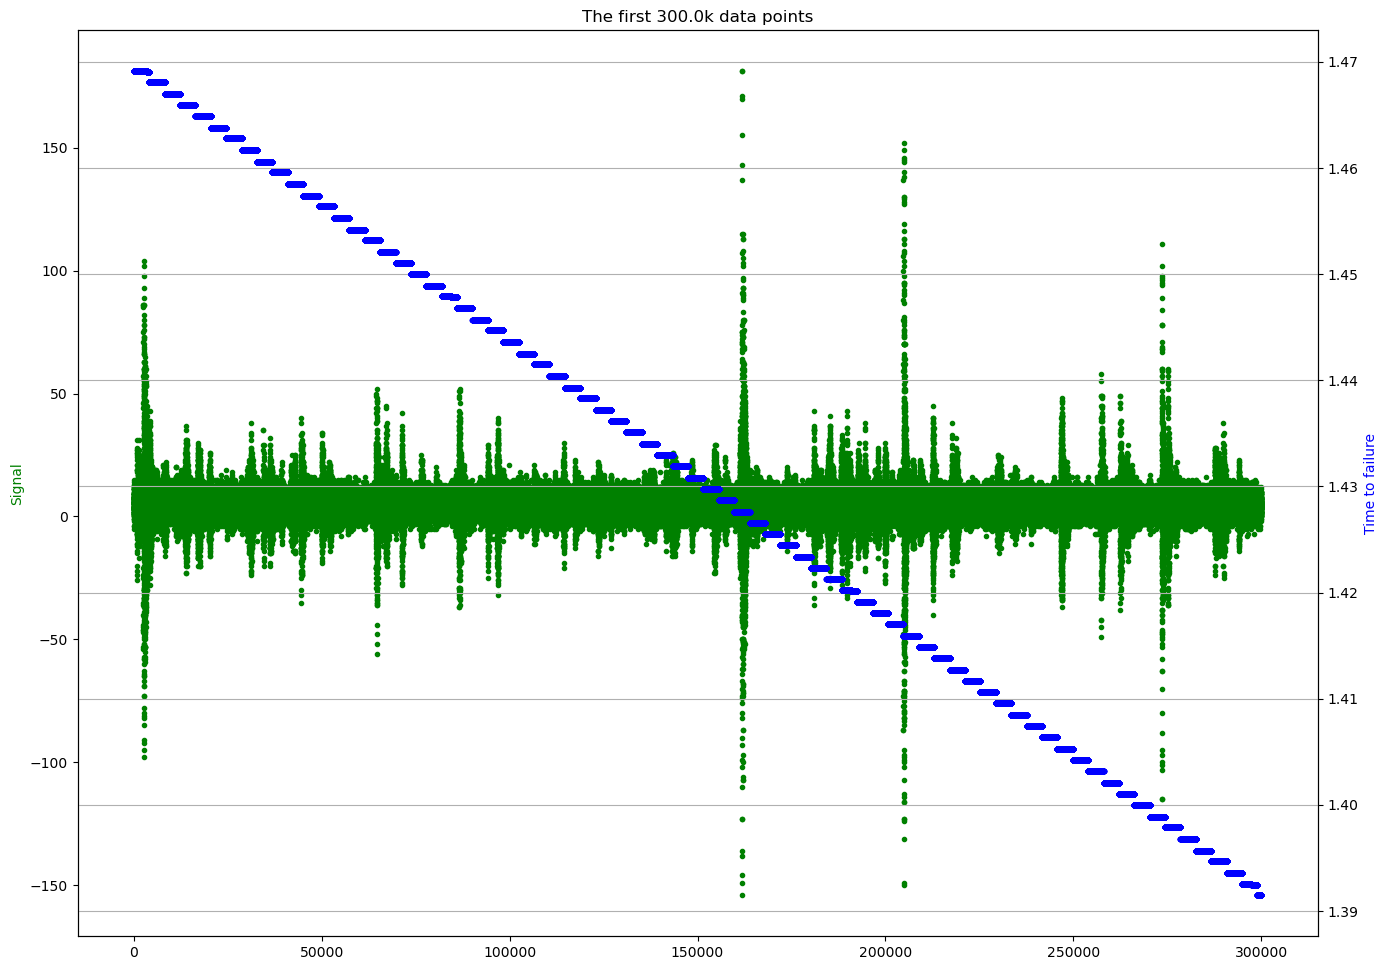

In [9]:
fig, ax1 = plt.subplots(1,1,figsize=(16, 12), dpi=100 )
ax2 = ax1.twinx()
ax1.plot(df_tr_sec['acoustic_data'], 'g.')
ax2.plot(df_tr_sec['time_to_failure'], 'b.')


ax1.set_ylabel('Signal', color='g')
ax2.set_ylabel('Time to failure', color='b')
ax2.grid()
plt.title(f'The first {records /1000}k data points');

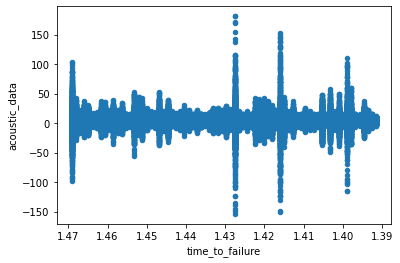

In [10]:
df_tr_sec.plot('time_to_failure','acoustic_data',kind = 'scatter')
plt.gca().invert_xaxis()

1.09999987e-09    128457
1.10000009e-09    119310
1.10000031e-09     36632
1.09999965e-09     15527
1.09549550e-03        35
9.95495500e-04        21
1.09549550e-03        11
9.95495500e-04         6
Name: dt, dtype: int64


C:\anaconda\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\anaconda\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


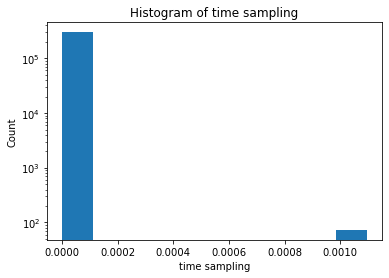

In [11]:
time2fail_np = df_tr_sec['time_to_failure'].to_numpy()
# dt_np = time2fail_np[0:-1] - time2fail_np[1:] 
dt = pd.Series(-df_tr_sec['time_to_failure'].diff(), name='dt')
print(dt.value_counts())
plt.hist(dt.sort_values()[1:])# remove the time difference between two segement, which is about -11
plt.title('Histogram of time sampling')
plt.ylabel('Count')
plt.yscale('log')
plt.xlabel('time sampling');

`acoustic_data` distribute unevenly.

From `time_to_failure`, the equipment may work a while to acquire signal at high frequency (1.1e-9 s), and then take a rest (1e-3 s)before next aquisition.

The sampling rate is not a constant, and the distribution of time step is bimodal with one large timestep and a small timestep.

Try resample with the large timestep later.



## 2.5.2 Truncate training data for each earthquake event

In [ ]:
# using chunk to manipulate the raw train data
filenum = 0
j = 0
previous_df = pd.DataFrame()
total_missing = np.array([0,0])
total_records = 0
min_time = 100000

for chunk in pd.read_csv(filename, chunksize = 1e7):
    # count missing value in each column

    total_missing += chunk.isna().sum().to_numpy()
    total_records += len(chunk)
    min_time = np.array([chunk.iloc[-1,1], min_time]).min()
    
    j += 1
#     print('chunk', j)
    dt_df = chunk[['time_to_failure']].shift(fill_value = chunk.iloc[0]['time_to_failure']) - chunk[['time_to_failure']]
    # find the last index of an earthquake event
    idx = dt_df[dt_df['time_to_failure'] < 0].index
    
    if len(idx) == 0:
        previous_df = pd.concat([previous_df,chunk])
    else:
        prev_i = chunk.index[0]
#         print('idx', idx)
        for i in idx:
            # save each earthquake event in a pickle file
            pd.concat([previous_df, chunk.loc[prev_i:i, :]]).to_pickle('D:/DataScience/traindata/train_sec_' + str(filenum) + '.pkl')
            filenum += 1
            prev_i = i
        previous_df = chunk.loc[i:, :]
#     print('filename', filenum)

# The last earthquake file    
previous_df.to_pickle('D:/DataScience/traindata/train_sec_' + str(filenum) + '.pkl')

In [ ]:
print("nan for two variables: ", total_missing)
print("Total records: ", total_records)
print("Last time of recording: ", min_time)

## 2.5.3 Check tuncated data

In [ ]:
def plot_train_segment(fileobject):
    df = pd.read_pickle(fileobject)
    print(df.columns)
    print('Records number:',len(df))
    df.plot(x = 'time_to_failure', y = 'acoustic_data')
    
    plt.gca().invert_xaxis()
    plt.title(fileobject[31:-4])
    plt.savefig("../images/" + fileobject[25:-4] + ".jpg")
    #     plt.close()

In [ ]:
pathlist = ['D:/DataScience/traindata/train_sec_' + str(num) + '.pkl' for num in range (0,17)]


In [ ]:
# plot the training segment and save figure
for path in pathlist[4:6]:
    plot_train_segment(path)

In [ ]:
df_tr_end = pd.read_pickle(pathlist[-1])
df_tr_end.iloc[-5:]

`train_sec_16` is not complete, i.e., it does not records the failure event

## 2.5.4 Pandas profiling for a training segment

In [ ]:
df_tr_sec = pd.read_pickle(pathlist[7])

In [ ]:
profile = ProfileReport(df_tr_sec, title="Pandas Profiling Report of the Training Data 6")

In [ ]:
# profile.to_widgets()

In [ ]:
profile.to_file("../report/training_data_report_6.html")

## 2.5.5 Resampling the training data with 1 ms sampling rate

In [12]:
# power spectrum density (square of amplitude spectrum)
def psd(input_signal):
    f, Pxx_den = signal.periodogram(input_signal, fs = 1/1.1e-9)
    f_dom = f[np.argmax(Pxx_den)]
    return f, Pxx_den, f_dom

In [13]:
def iqr(X):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    iqr_X = Q3 - Q1
    return iqr_X

In [14]:
def create_feature(X):
    mean_X = X.mean()
    median_X = X.median()
    std_X = X.std()
    iqr_X = iqr(X)
    range_X = np.ptp(X)
#     min_X = np.min(X)
#     max_X = np.max(X)
#     f, Pxx_den, f_dom_X = psd(X)
    return [mean_X, median_X, std_X, iqr_X, range_X]

In [15]:
def create_lag_feature(X, periods= 0):
    feature_list = []
    for period in range(1,periods):
        feature_list.extend(create_feature(X.diff(periods))) 
    return feature_list

In [16]:
def create_feature_by_smplrt(df, precision):
    if precision == 4:
        col_name = 'ttf_ms'
    elif precision == 6:
        col_name = 'ttf_us'
        
    # Create feature using statistics
    df[col_name] = df['time_to_failure'].round(precision).astype('str')
    df_agg = df.groupby(col_name)['acoustic_data'].agg(create_feature)
    df_agg = pd.DataFrame(df_agg.tolist(), index= df_agg.index, columns = [ 'mean','median','std','iqr','range'])
    
    # prepare feature names of lagging data in time domain
    col_name_by_lag = [i + '_lag' for i in ['mean','median','std','iqr','range']]
    col_names = []
    for j in range(1,11):
        col_names.extend([name + '_'+ str(j) for name in col_name_by_lag])
        
    # Create feature using time lagging on acoustic data
    df_lag_agg = df.groupby(col_name)['acoustic_data'].agg(create_lag_feature, periods = 11)
    df_lag_agg = pd.DataFrame(df_lag_agg.tolist(), index= df_lag_agg.index, columns =col_names)
    
    # Merge features in time domains
    df_time = df_agg.merge(df_lag_agg, how = 'left',left_index = True, right_index = True)

    # Frequency domain statistics in sampling signal
    df_psd = df.groupby(col_name)['acoustic_data'].agg(psd)
    df_psd = pd.DataFrame(df_psd.tolist(), index= df_psd.index, columns = ['freq', 'psd','f_dom'])
    
    # prepare feature names in frequency domain
    fsecs = ['f_sec' + str(num) for num in range(1,11)] # variable names
    df_f = pd.DataFrame(columns = fsecs)
    for index, row in df_psd.iterrows():
        f_dict = dict()
        freq_sec = np.linspace(0,1e8,11)
        PSD = row['psd']
        freq = row['freq']
        area = PSD[freq < 1e8].sum()

        for idx, fsec in enumerate(fsecs):
            row_filter = (freq >= freq_sec[idx]) & (freq < freq_sec[idx+1])
            pzone = PSD[row_filter].sum()    
            f_dict[fsec] = pzone / area
        temp = pd.DataFrame(f_dict,index =[index] )
        df_f = df_f.append(temp) 
    df_psd = df_psd.merge(df_f, how = 'left', left_index = True, right_index = True)
    
    df_new_smplrt = df_time.merge(df_psd, how = 'left', left_index = True, right_index = True).reset_index()
    df_new_smplrt[col_name] = df_new_smplrt[col_name].astype('float')
    return df_new_smplrt

### 2.5.5.1 Create feature using statistics on 1 ms groups

In [18]:
df_tr_sec['ttf_round'] = df_tr_sec['time_to_failure'].round(4).astype('str')
df_agg = df_tr_sec.groupby('ttf_round')['acoustic_data'].agg(create_feature)
df_agg = pd.DataFrame(df_agg.tolist(), index= df_agg.index, columns = [ 'mean','median','std','iqr','diff'])
# df_agg.reset_index(inplace = True)

df_agg.head()

,mean,median,std,iqr,diff
ttf_round,,,,,
1.3915,4.58207452,5.0,2.67333776,3.0,17
1.3925,5.05908203,5.0,3.18266451,4.0,23
1.3936,4.91308594,5.0,3.48529297,4.0,37
1.3947,4.75463867,5.0,6.27187088,7.0,63
1.3957,4.66552734,5.0,2.75112464,4.0,21


### 2.5.5.2 Create feature using time lagging on acoustic data

In [19]:
# prepare feature names of lagging data in time domain
col_name_by_lag = [i + '_lag' for i in ['mean','median','std','iqr', 'diff']]

col_names = []
for j in range(1,11):
    col_names.extend([name + '_'+ str(j) for name in col_name_by_lag])
col_names[:10]

['mean_lag_1',
 'median_lag_1',
 'std_lag_1',
 'iqr_lag_1',
 'diff_lag_1',
 'mean_lag_2',
 'median_lag_2',
 'std_lag_2',
 'iqr_lag_2',
 'diff_lag_2']

In [20]:
df_tr_sec['ttf_round'] = df_tr_sec['time_to_failure'].round(4).astype('str')
df_lag_agg = df_tr_sec.groupby('ttf_round')['acoustic_data'].agg(create_lag_feature, periods = 11)
df_lag_agg = pd.DataFrame(df_lag_agg.tolist(), index= df_lag_agg.index, columns =col_names)
df_lag_agg.head(5).T

ttf_round,1.3915,1.3925,1.3936,1.3947,1.3957
mean_lag_1,-0.01527495,0.00244798,-0.00489596,-0.01346389,-0.00220318
median_lag_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
std_lag_1,3.85580713,4.81127612,5.23282373,10.03402951,4.00822429
iqr_lag_1,4.00000000,6.00000000,6.00000000,10.00000000,6.00000000
diff_lag_1,NaN,NaN,NaN,NaN,NaN
mean_lag_2,-0.01527495,0.00244798,-0.00489596,-0.01346389,-0.00220318
median_lag_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
std_lag_2,3.85580713,4.81127612,5.23282373,10.03402951,4.00822429
iqr_lag_2,4.00000000,6.00000000,6.00000000,10.00000000,6.00000000
diff_lag_2,NaN,NaN,NaN,NaN,NaN


### 2.5.5.3 Time domain features compilation

In [21]:
df_tr_agg = df_agg.merge(df_lag_agg, how = 'left',left_index = True, right_index = True)
df_tr_agg.head(5).T

ttf_round,1.3915,1.3925,1.3936,1.3947,1.3957
mean,4.58207452,5.05908203,4.91308594,4.75463867,4.66552734
median,5.00000000,5.00000000,5.00000000,5.00000000,5.00000000
std,2.67333776,3.18266451,3.48529297,6.27187088,2.75112464
iqr,3.00000000,4.00000000,4.00000000,7.00000000,4.00000000
diff,17.00000000,23.00000000,37.00000000,63.00000000,21.00000000
mean_lag_1,-0.01527495,0.00244798,-0.00489596,-0.01346389,-0.00220318
median_lag_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
std_lag_1,3.85580713,4.81127612,5.23282373,10.03402951,4.00822429
iqr_lag_1,4.00000000,6.00000000,6.00000000,10.00000000,6.00000000
diff_lag_1,NaN,NaN,NaN,NaN,NaN


### 2.5.5.4 Frequency domain in 1 ms sampling signal

Plot periodogram (square of amplitude spectrum)

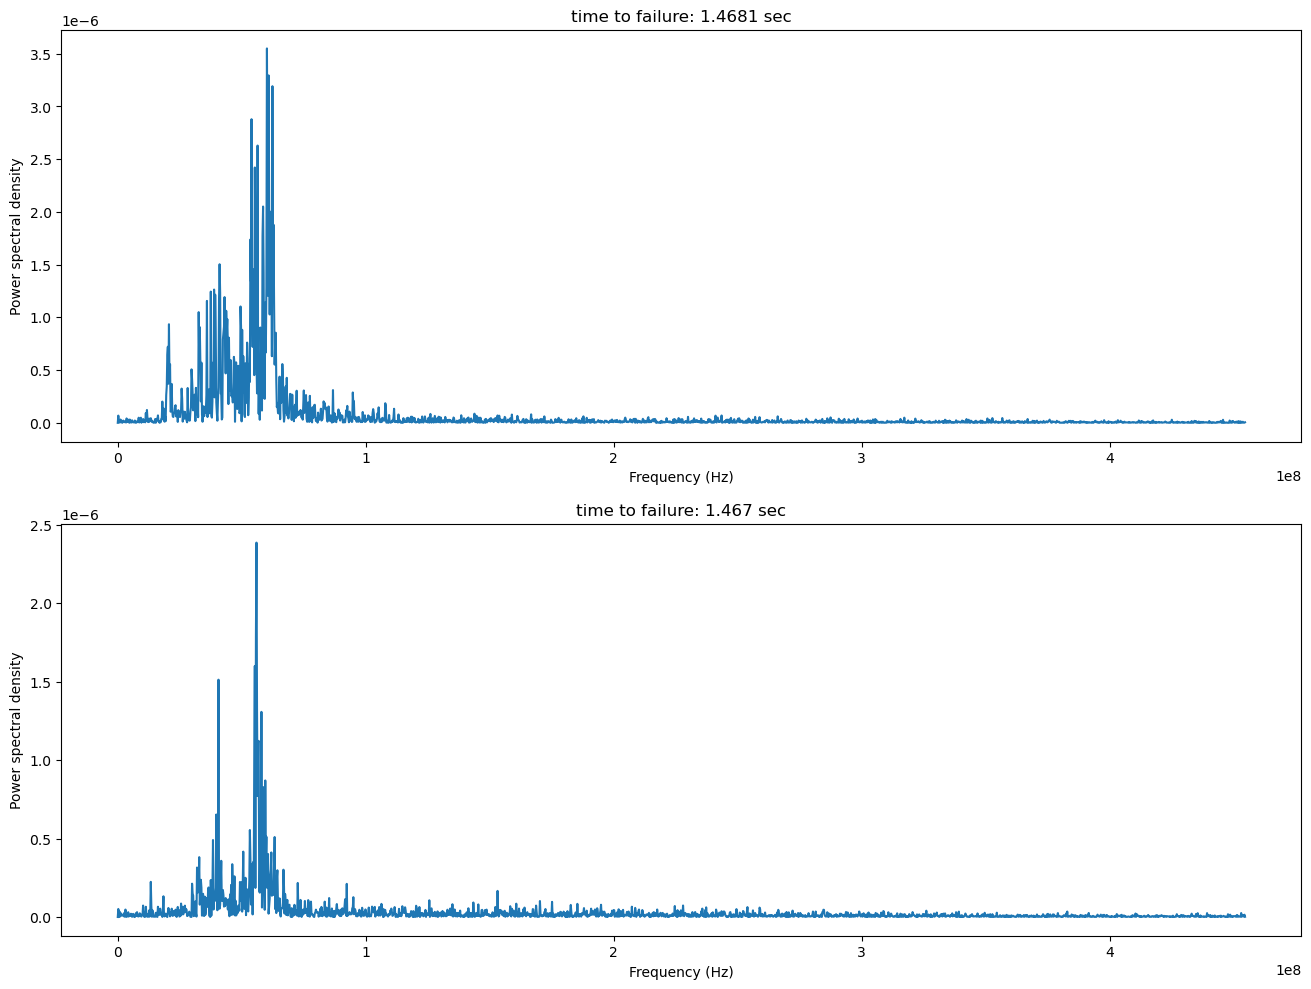

In [22]:
row1 = df_tr_sec['ttf_round'] == df_tr_sec['ttf_round'].unique()[1]
f1, Pxx_den1, f_dom1 = psd(df_tr_sec.loc[row1,'acoustic_data'])

row2 = df_tr_sec['ttf_round'] == df_tr_sec['ttf_round'].unique()[2]
f2, Pxx_den2, f_dom2 = psd(df_tr_sec.loc[row2,'acoustic_data'])

fig, ax_list = plt.subplots(2,1,figsize=(16, 12), dpi=100 )
ax = ax_list[0]
ax.plot(f1,Pxx_den1)
ax.set_ylabel('Power spectral density')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('time to failure: ' + df_tr_sec['ttf_round'].unique()[1] + ' sec' )

ax = ax_list[1]
ax.plot(f2,Pxx_den2)
ax.set_ylabel('Power spectral density')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('time to failure: ' + df_tr_sec['ttf_round'].unique()[2] + ' sec' );

The frequency component mainly distribute in 1e8 Hz. Divide this frequency interval to 10 buckets, calculate the probability to create some features

In [23]:
df_psd = df_tr_sec.groupby('ttf_round')['acoustic_data'].agg(psd)
df_psd = pd.DataFrame(df_psd.tolist(), index= df_psd.index, columns = ['freq', 'psd','f_dom'])
df_psd.head()

,freq,psd,f_dom
ttf_round,,,
1.3915,"[0.0, 915499.4049253869, 1830998.8098507738, 2...","[1.3428144446512559e-37, 8.100726340270141e-08...",4.11974732e+07
1.3925,"[0.0, 221946.02272727274, 443892.04545454547, ...","[0.0, 2.270845962774322e-07, 6.929581817218506...",5.50426136e+07
1.3936,"[0.0, 221946.02272727274, 443892.04545454547, ...","[0.0, 1.0597400935615749e-07, 1.44794641752008...",5.83718040e+07
1.3947,"[0.0, 221946.02272727274, 443892.04545454547, ...","[0.0, 3.130938871962171e-08, 3.898596850334747...",5.72620739e+07
1.3957,"[0.0, 221946.02272727274, 443892.04545454547, ...","[0.0, 5.472453103054592e-08, 6.081979072702592...",5.70401278e+07


In [24]:
fsecs = ['f_sec' + str(num) for num in range(1,11)] # variable names
df_f = pd.DataFrame(columns = fsecs)
for index, row in df_psd.iterrows():
#     print(type(row))
    f_dict = dict()
    freq_sec = np.linspace(0,1e8,11)
    PSD = row['psd']
    freq = row['freq']
    area = PSD[freq < 1e8].sum()

    for idx, fsec in enumerate(fsecs):
        row_filter = (freq >= freq_sec[idx]) & (freq < freq_sec[idx+1])
        pzone = PSD[row_filter].sum()    
        f_dict[fsec] = pzone / area
    temp = pd.DataFrame(f_dict,index =[index] )
#     print(temp)
    df_f = df_f.append(temp) 
df_psd = df_psd.merge(df_f, how = 'left', left_index = True, right_index = True)
df_psd.head().T

ttf_round,1.3915,1.3925,1.3936,1.3947,1.3957
freq,"[0.0, 915499.4049253869, 1830998.8098507738, 2...","[0.0, 221946.02272727274, 443892.04545454547, ...","[0.0, 221946.02272727274, 443892.04545454547, ...","[0.0, 221946.02272727274, 443892.04545454547, ...","[0.0, 221946.02272727274, 443892.04545454547, ..."
psd,"[1.3428144446512559e-37, 8.100726340270141e-08...","[0.0, 2.270845962774322e-07, 6.929581817218506...","[0.0, 1.0597400935615749e-07, 1.44794641752008...","[0.0, 3.130938871962171e-08, 3.898596850334747...","[0.0, 5.472453103054592e-08, 6.081979072702592..."
f_dom,41197473,55042614,58371804,57262074,57040128
f_sec1,0.07664031,0.031436384,0.02003897,0.0054255804,0.042961887
f_sec2,0.046459775,0.042591324,0.051617388,0.034994434,0.043137589
f_sec3,0.084084506,0.074700064,0.045583368,0.034124176,0.074028799
f_sec4,0.077247338,0.15952742,0.063530897,0.10169388,0.1139076
f_sec5,0.19438501,0.12474506,0.080504829,0.076497685,0.10937446
f_sec6,0.14306865,0.26063663,0.4409548,0.53825017,0.22637907
f_sec7,0.11916197,0.13392263,0.17125129,0.12567864,0.14710399


### 2.5.5.5 Merge time- and frequency-domain features
merge time-lag features `df_lag_all` with frequency-domain features `df_psd`

In [25]:
df_agg_all = df_tr_agg.merge(df_psd, how = 'left', left_index = True, right_index = True).reset_index()
df_agg_all['ttf_round'] = df_agg_all['ttf_round'].astype('float')
df_agg_all.head(5).T

,0,1,2,3,4
ttf_round,1.3915,1.3925,1.3936,1.3947,1.3957
mean,4.5820745,5.059082,4.9130859,4.7546387,4.6655273
median,5,5,5,5,5
std,2.6733378,3.1826645,3.485293,6.2718709,2.7511246
iqr,3,4,4,7,4
...,...,...,...,...,...
f_sec6,0.14306865,0.26063663,0.4409548,0.53825017,0.22637907
f_sec7,0.11916197,0.13392263,0.17125129,0.12567864,0.14710399
f_sec8,0.064703889,0.064565389,0.044688455,0.028706517,0.081306024
f_sec9,0.11016257,0.056461049,0.038616677,0.038198763,0.072775448


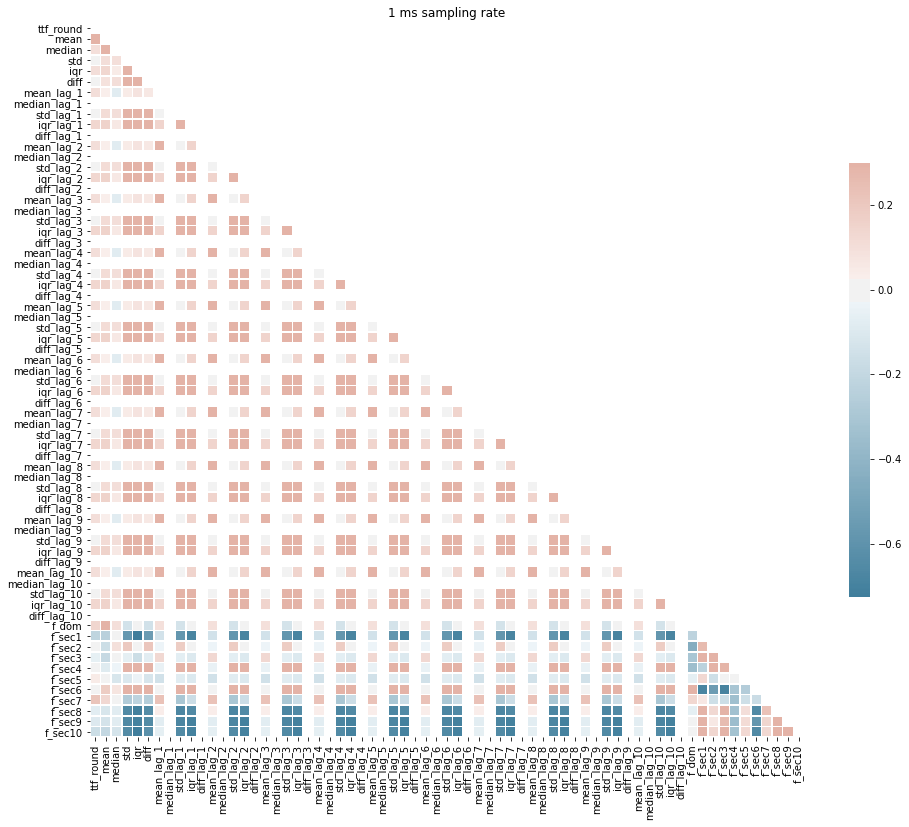

In [26]:
corr_lag = df_agg_all.corr()
mask = np.triu(np.ones_like(corr_lag, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(16, 16))
ax = sns.heatmap(corr_lag, mask=mask, cmap=cmap, vmax=.3, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('1 ms sampling rate');

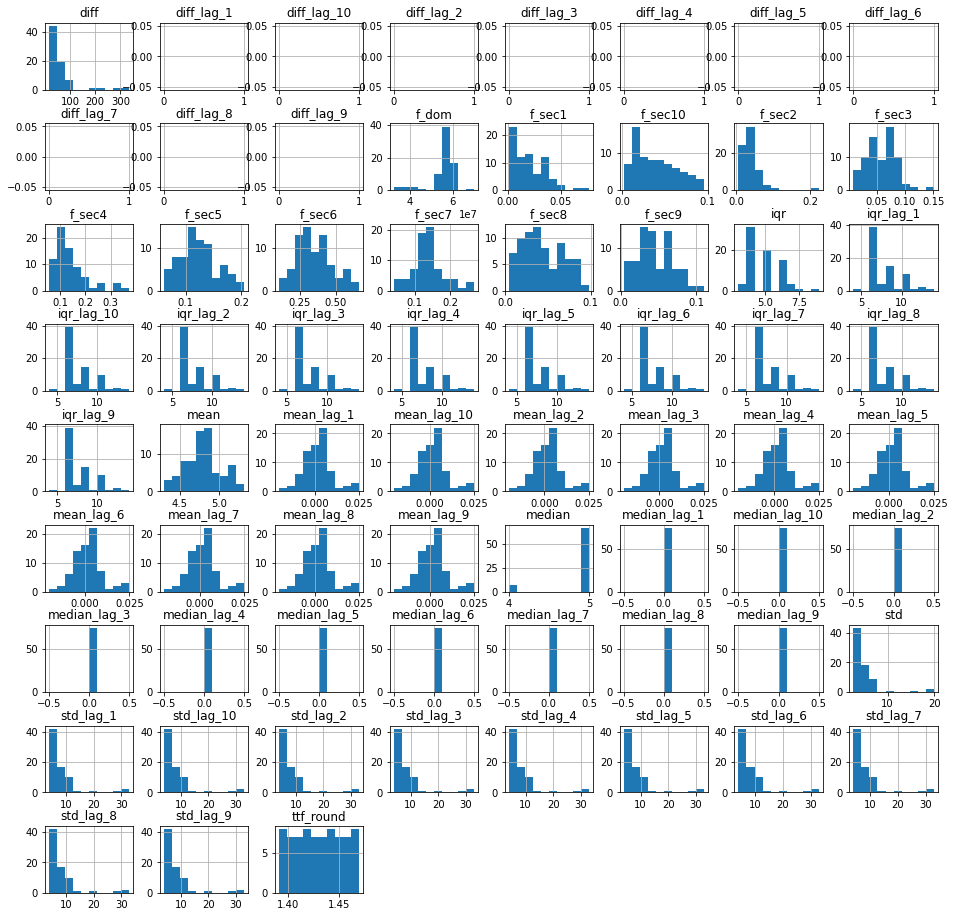

In [27]:
df_agg_all.hist(figsize=(16,16))
plt.subplots_adjust(hspace=0.5);

Q: why median and iqr only have a precision of 1

Because `acoustic_data` is int type.

In [28]:
df_ms = create_feature_by_smplrt(df_tr_sec, 4)
df_ms.head(5).T

,0,1,2,3,4
ttf_ms,1.3915,1.3925,1.3936,1.3947,1.3957
mean,4.5820745,5.059082,4.9130859,4.7546387,4.6655273
median,5,5,5,5,5
std,2.6733378,3.1826645,3.485293,6.2718709,2.7511246
iqr,3,4,4,7,4
...,...,...,...,...,...
f_sec6,0.14306865,0.26063663,0.4409548,0.53825017,0.22637907
f_sec7,0.11916197,0.13392263,0.17125129,0.12567864,0.14710399
f_sec8,0.064703889,0.064565389,0.044688455,0.028706517,0.081306024
f_sec9,0.11016257,0.056461049,0.038616677,0.038198763,0.072775448


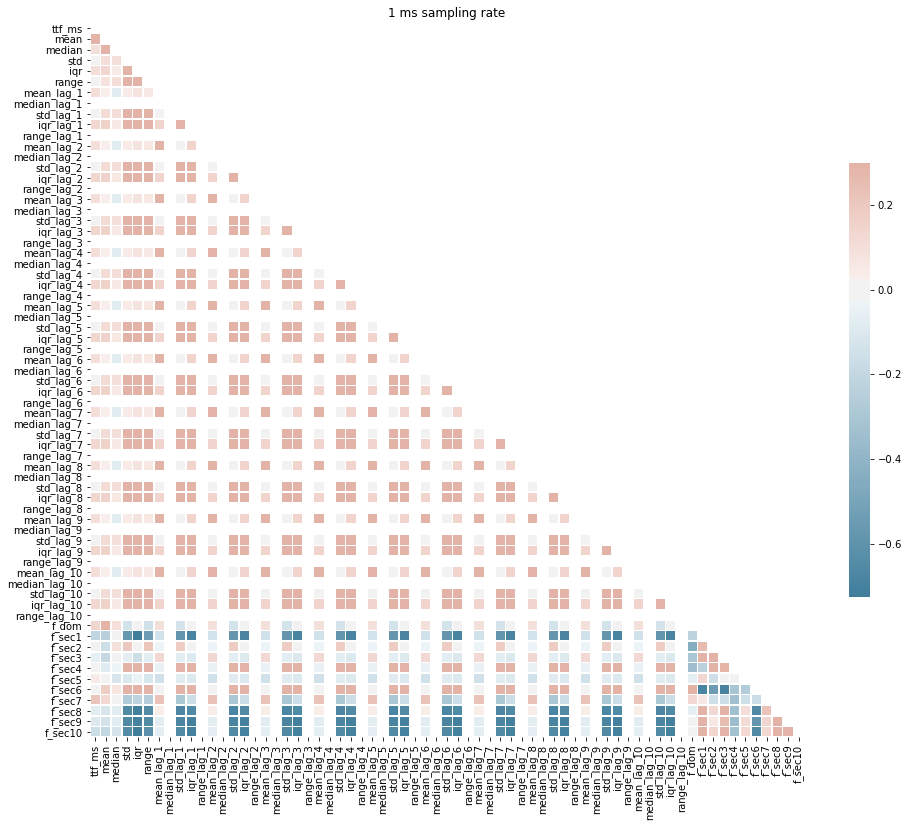

In [29]:
corr_lag = df_ms.corr()
mask = np.triu(np.ones_like(corr_lag, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(16, 16))
ax = sns.heatmap(corr_lag, mask=mask, cmap=cmap, vmax=.3, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('1 ms sampling rate');

## 2.5.6 Resampling the training data with 1 us sampling rate

In [30]:
df_us = create_feature_by_smplrt(df_tr_sec, 6)
df_us.head(5).T

,0,1,2,3,4
ttf_us,1.391499,1.3915,1.392495,1.392496,1.392497
mean,4.8097826,4.2970522,5.5263158,4.750275,4.8943894
median,5,4,6,5,5
std,2.6587619,2.6671768,2.6743311,3.164769,3.193789
iqr,4,3,3,4,4
...,...,...,...,...,...
f_sec6,0.14081957,0.13523299,0,0.13916917,0.38091389
f_sec7,0.11068027,0.042138271,0,0.23241923,0.075942986
f_sec8,0.053483838,0.15320002,0,0.094303356,0.050370144
f_sec9,0.12304354,0.11498511,0,0.042020102,0.052588085


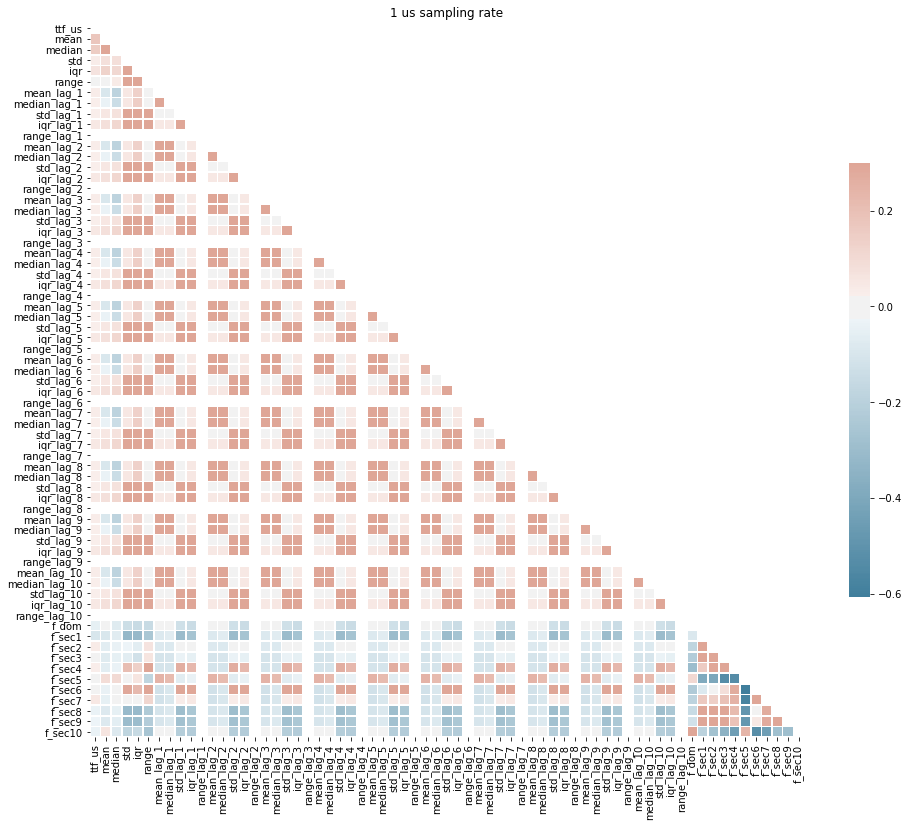

In [31]:
corr_lag = df_us.corr()
mask = np.triu(np.ones_like(corr_lag, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(16, 16))
ax = sns.heatmap(corr_lag, mask=mask, cmap=cmap, vmax=.3, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('1 us sampling rate');

# 2.6 Load the testing data

In [ ]:
testfilepath = "../raw_data/test/"
os.chdir(testfilepath)
testfiles = glob.glob("*.csv")
print(testfiles[0:5])

In [ ]:
def plot_test_file(fileobject):
    df = pd.read_csv(fileobject)
    print(df.describe())
    df.plot(y = 'acoustic_data')
    plt.title(fileobject[0:-4])

In [ ]:
df_te = pd.read_csv(testfiles[0])
df_te.head()

In [ ]:
for testfile in testfiles[0:3]:
    print(len(testfile))
    plot_test_file(testfile)
    

# 2.7 Save data

In [36]:
# save the data to a new pickle file
df_ms.to_pickle('../data/train_ms_section.pkl')

In [37]:
df_us.to_pickle('../data/train_us_section.pkl')

In [ ]:
.to_pickle('D:/DataScience/traindata/train_sec_' + str(filenum) + '.pkl')

# 2.8 Summary

For the training data:
* The data has zero missing values for both columns
* The data has only two column ,`acoustic_data` in int type and `time_to_failure` in float type. `time_to_failure` is our target.
* The data has 629,145,480 records, too large to operate.
* `acoustic_data` is the acoustic emission signal (amplitude), consisting of many peaks and troughts. 
* `time_to_failure` decreases from a value to zero periodically. The data should be truncated based on it.
* 17 segments were obtained after analyzing chunk data in the rawdata. 
* Each training segment has different time length
* The first one only has about two seconds record to earthquake. The last one is not complete because the `time_to_failure` is 9.75 s, far from zero.
* After `acoustic_data` reaches a extremly large event, the eqrthquake occurs soon in each training segment, and `time_to_failure` is less than 0.5s.

For the testing data:
* Only one row in each file, which is the `acoustic_data`
* Each segment contains 150k records, a small segment from a complete earthquake event. By comparision, records in training data is about 200 times of the test data. This may inspire us the feature extraction from the training data
* Similar to the training data, the average `acoustic_data` of a test data are small, while some abnormal `acoustic_data` exists. These determines what a feature is.
* Most test data may not contain the extremly large event with an absolute of amplitude over 1000. They contains peaks at a scale of several hundred amplitude

7/11/2022
For the training data:

* Resampling using groupby on round precision = 4 for `time_to_failure`
* Time lagging is tried on `acoustic_data` to create features. However, what time step is an optimum value?